In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from timm import create_model
import cv2
import json
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size=2
img_size=512
label_map=json.load(open('he_label_map.json'))
tf = ToTensor()
topilimage = torchvision.transforms.ToPILImage()
def createDirectory(directory):
    """_summary_
        create Directory
    Args:
        directory (string): file_path
    """    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")
        
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [2]:

class CustomDataset(Dataset):
    def __init__(self, image_list, label_list,img_size,json_file=None):
        self.img_path = image_list
        self.label = label_list
        self.json_label=json_file
        self.img_size = img_size    
        
    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            label = transform(label)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            label = transform(label)
            image = transform(image)
            
        return image,label
    
    def __len__(self):
        return len(self.img_path)
    
    def random_crop(self, image,label):
        h, w = image.shape[1:3]
        r = self.img_size / min(h, w)
        
        # 이미지가 input_size보다 큰 경우 (r < 1) -> 랜덤 크롭
        if r < 1:
            # 안전하게 크롭 범위 계산
            max_h = max(0, h - self.img_size)
            max_w = max(0, w - self.img_size)
            h1 = random.randint(0, max_h) if max_h > 0 else 0
            w1 = random.randint(0, max_w) if max_w > 0 else 0
            image = image[:,h1:h1 + self.img_size, w1:w1 + self.img_size]
            label = label[:,h1:h1 + self.img_size, w1:w1 + self.img_size]
        else:
            # 이미지가 input_size보다 작거나 같은 경우 (r >= 1) -> 패딩
            h1 = 0
            w1 = 0
            pad_image = torch.ones((3,self.img_size, self.img_size), dtype=torch.uint8)*255
            pad_label=torch.zeros((len(self.json_label),self.img_size, self.img_size), dtype=torch.uint8)
            pad_image[:,:min(h,self.img_size), :min(w,self.img_size)] = image[:,:min(h,self.img_size), :min(w,self.img_size)]
            pad_label[:,:min(h,self.img_size), :min(w,self.img_size)] = label[:,:min(h,self.img_size), :min(w,self.img_size)]
            image = pad_image
            label=pad_label
        return image, label
    
    def __getitem__(self, idx):
        image=torch.from_numpy(np.array(Image.open(self.img_path[idx]).convert('RGB')))
        image=image.permute(2,0,1)/255.0
        image=image*2.0-1.0
        label_temp=255-np.array(Image.open(self.label[idx]))+1
        label=np.zeros((len(self.json_label),label_temp.shape[0],label_temp.shape[1]),dtype=np.uint8)
        for i in range(len(self.json_label)):
            label[i,:,:][label_temp==list(self.json_label.values())[i]]=1
        label=torch.from_numpy(label)
        image,label=self.random_crop(image,label)

        image,label = self.trans(image,label)
        return image,label

img_path='../../data/IGNITE/images/he/'
img_list=glob(img_path+'*.png')
mask_list=[i.replace('/images','/annotations') for i in img_list]
train_img_list,test_img_list,train_mask_list,test_mask_list=train_test_split(img_list,mask_list,test_size=0.1,random_state=42)

train_dataset = CustomDataset(train_img_list, train_mask_list,img_size,json_file=label_map)

test_dataset = CustomDataset(test_img_list, test_mask_list,img_size,json_file=label_map)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)




In [3]:
model = smp.Segformer(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=len(label_map),                      # model output channels (number of classes in your dataset) 
    ).to(device)
def dice_loss(pred, target, num_classes=len(label_map)):
    smooth = 1e-6
    dice_per_class = torch.zeros((len(pred),num_classes)).to(pred.device)
    pred=F.softmax(pred,dim=1)
    for i in range(len(pred)):
        for class_id in range(num_classes):
            pred_class = pred[i, class_id, ...]
            target_class = target[i, class_id, ...]
            
            intersection = torch.sum(pred_class * target_class)
            A_sum = torch.sum(pred_class * pred_class)
            B_sum = torch.sum(target_class * target_class)
            dice_per_class[i,class_id] =(2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return 1-dice_per_class.mean()
summary(model,(batch_size,3,img_size,img_size))

Layer (type:depth-idx)                                  Output Shape              Param #
Segformer                                               [2, 17, 512, 512]         --
├─EfficientNetEncoder: 1-1                              [2, 3, 512, 512]          1,643,520
│    └─Conv2dStaticSamePadding: 2-1                     [2, 64, 256, 256]         1,728
│    │    └─ZeroPad2d: 3-1                              [2, 3, 513, 513]          --
│    └─BatchNorm2d: 2-2                                 [2, 64, 256, 256]         128
│    └─SiLU: 2-3                                        [2, 64, 256, 256]         --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [2, 32, 256, 256]         4,944
│    │    └─MBConvBlock: 3-3                            [2, 32, 256, 256]         1,992
│    │    └─MBConvBlock: 3-4                            [2, 32, 256, 256]         1,992
│    │    └─MBConvBlock: 3-5            

Image shape: torch.Size([3, 512, 512])
Label shape: torch.Size([17, 512, 512])
Image range: [-1.000, 1.000]
Label unique values: tensor([0, 1], dtype=torch.uint8)


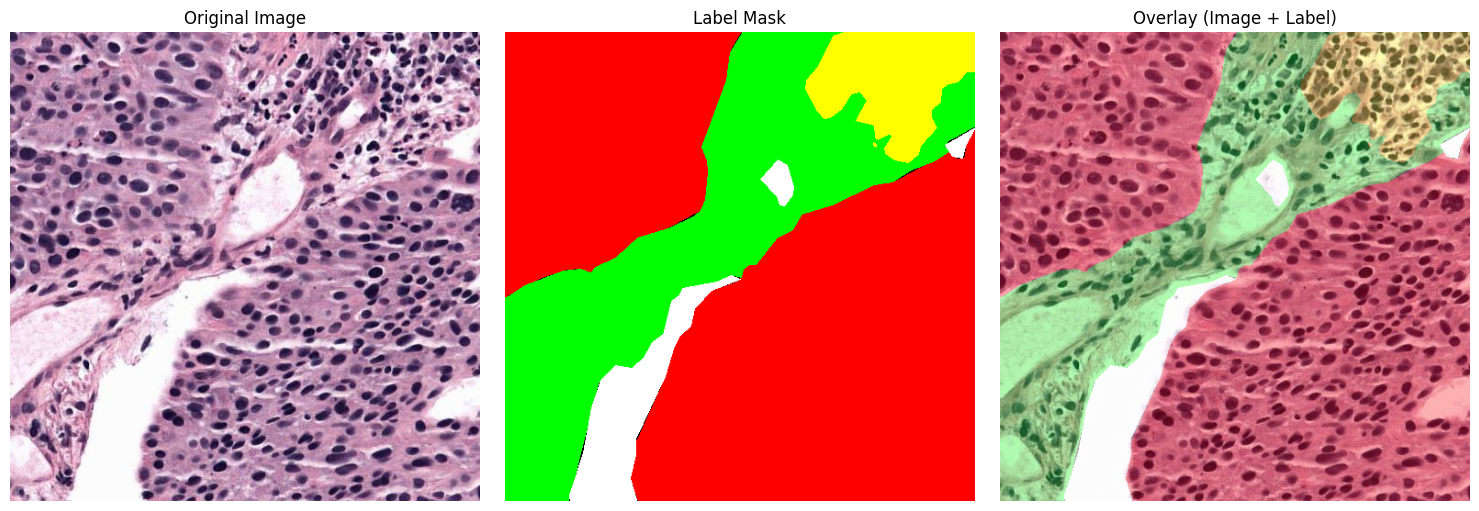


Class distribution:
Unannotated (ID: 0): 283 pixels (0.11%)
Background (ID: 1): 13577 pixels (5.18%)
Tumor epithelium (ID: 2): 160000 pixels (61.04%)
Stroma (ID: 4): 71842 pixels (27.41%)
Inflammation (ID: 5): 16442 pixels (6.27%)


In [4]:
# train_dataset[0] 데이터 확인 및 시각화
sample_image, sample_label = train_dataset[4]

print(f"Image shape: {sample_image.shape}")
print(f"Label shape: {sample_label.shape}")
print(f"Image range: [{sample_image.min():.3f}, {sample_image.max():.3f}]")
print(f"Label unique values: {torch.unique(sample_label)}")

# 17개 클래스를 RGB 색상으로 매핑
colors = [
    [0, 0, 0],        # 0: Unannotated - Black
    [255, 255, 255],  # 1: Background - White
    [255, 0, 0],      # 2: Tumor epithelium - Red
    [255, 165, 0],    # 3: Reactive epithelium - Orange
    [0, 255, 0],      # 4: Stroma - Green
    [255, 255, 0],    # 5: Inflammation - Yellow
    [0, 255, 255],    # 6: Alveolar tissue - Cyan
    [255, 192, 203],  # 7: Fatty tissue - Pink
    [128, 0, 128],    # 8: Necrotic tissue - Purple
    [255, 0, 255],    # 9: Erythrocytes - Magenta
    [0, 0, 255],      # 10: Bronchial epithelium - Blue
    [165, 42, 42],    # 11: Mucus/Plasma/Fluids - Brown
    [128, 128, 128],  # 12: Cartilage/Bone - Gray
    [0, 128, 0],      # 13: Macrophages - Dark Green
    [128, 0, 0],      # 14: Muscle - Maroon
    [255, 20, 147],   # 15: Liver - Deep Pink
    [255, 140, 0]     # 16: Keratinization - Dark Orange
]

# 이미지를 [0, 1] 범위로 정규화 (현재 [-1, 1] 범위)
normalized_image = (sample_image + 1.0) / 2.0

# 라벨을 argmax로 변환하여 클래스 인덱스 얻기
label_indices = torch.argmax(sample_label, 0)

# 라벨을 RGB 색상으로 변환
label_rgb = torch.zeros((3, img_size, img_size))
for class_id in range(len(label_map)):
    mask = (label_indices == class_id).float()
    label_rgb[0] += mask * colors[class_id][0] / 255.0
    label_rgb[1] += mask * colors[class_id][1] / 255.0
    label_rgb[2] += mask * colors[class_id][2] / 255.0

# 오버레이 생성 (이미지 70% + 라벨 30%)
overlay = normalized_image * 0.7 + label_rgb * 0.3

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 원본 이미지
axes[0].imshow(normalized_image.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')

# 라벨 마스크
axes[1].imshow(label_rgb.permute(1, 2, 0))
axes[1].set_title('Label Mask')
axes[1].axis('off')

# 오버레이
axes[2].imshow(overlay.permute(1, 2, 0))
axes[2].set_title('Overlay (Image + Label)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# 각 클래스별 픽셀 수 확인
print("\nClass distribution:")
for class_name, class_id in label_map.items():
    pixel_count = (label_indices == class_id).sum().item()
    percentage = (pixel_count / (img_size * img_size)) * 100
    if pixel_count > 0:
        print(f"{class_name} (ID: {class_id}): {pixel_count} pixels ({percentage:.2f}%)")

In [ ]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]

MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-3)

# Learning Rate Scheduler 설정
# 옵션 1: StepLR - 특정 epoch마다 학습률 감소
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# 옵션 2: ReduceLROnPlateau - validation loss가 개선되지 않을 때 학습률 감소
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# 옵션 3: CosineAnnealingLR - 코사인 함수를 이용한 학습률 스케줄링
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

# 옵션 4: ExponentialLR - 지수적으로 학습률 감소
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

metrics = defaultdict(float)
for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y) # cost 구함
        acc=1-cost.item()
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f} lr: {optimizer.param_groups[0]['lr']:.6f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count))
#test
    val=tqdm(test_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y) # cost 구함
            acc=1-cost.item()
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"test epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count))
        
    # Learning Rate Scheduler 적용
    # StepLR, CosineAnnealingLR, ExponentialLR의 경우
    scheduler.step()
    
    # ReduceLROnPlateau의 경우 (위 줄을 주석처리하고 아래 줄 사용)
    # scheduler.step(val_running_loss/count)
        
    if MIN_loss>(val_running_loss/count):
        createDirectory('../../model/HnE_Organizational_Segmentation/')
        torch.save(model.state_dict(), '../../model/HnE_Organizational_Segmentation/check.pt')
        MIN_loss=(val_running_loss/count)
    
    # 예측 마스크 생성 (17개 클래스를 색상으로 매핑)
    pred_mask1 = torch.argmax(predict[0], 0).cpu()
    pred_mask = torch.zeros((3, img_size, img_size))
    
    # 17개 클래스를 RGB 색상으로 매핑
    colors = [
        [0, 0, 0],        # 0: Unannotated - Black
        [255, 255, 255],  # 1: Background - White
        [255, 0, 0],      # 2: Tumor epithelium - Red
        [255, 165, 0],    # 3: Reactive epithelium - Orange
        [0, 255, 0],      # 4: Stroma - Green
        [255, 255, 0],    # 5: Inflammation - Yellow
        [0, 255, 255],    # 6: Alveolar tissue - Cyan
        [255, 192, 203],  # 7: Fatty tissue - Pink
        [128, 0, 128],    # 8: Necrotic tissue - Purple
        [255, 0, 255],    # 9: Erythrocytes - Magenta
        [0, 0, 255],      # 10: Bronchial epithelium - Blue
        [165, 42, 42],    # 11: Mucus/Plasma/Fluids - Brown
        [128, 128, 128],  # 12: Cartilage/Bone - Gray
        [0, 128, 0],      # 13: Macrophages - Dark Green
        [128, 0, 0],      # 14: Muscle - Maroon
        [255, 20, 147],   # 15: Liver - Deep Pink
        [255, 140, 0]     # 16: Keratinization - Dark Orange
    ]
    
    for class_id in range(len(label_map)):
        mask = (pred_mask1 == class_id).float()
        pred_mask[0] += mask * colors[class_id][0] / 255.0
        pred_mask[1] += mask * colors[class_id][1] / 255.0
        pred_mask[2] += mask * colors[class_id][2] / 255.0
    
    # 라벨 마스크 생성 (17개 클래스를 색상으로 매핑)
    label_mask1 = torch.argmax(y[0], 0).cpu()
    label_mask = torch.zeros((3, img_size, img_size))
    
    for class_id in range(len(label_map)):
        mask = (label_mask1 == class_id).float()
        label_mask[0] += mask * colors[class_id][0] / 255.0
        label_mask[1] += mask * colors[class_id][1] / 255.0
        label_mask[2] += mask * colors[class_id][2] / 255.0
    
    # 오버레이 생성
    normalized_x = (x[0].cpu() + 1.0) / 2.0  # [-1,1] -> [0,1] 변환
    label_overlay = normalized_x * 0.7 + label_mask * 0.3
    pred_overlay = normalized_x * 0.7 + pred_mask * 0.3

    createDirectory('../../results/HnE_Organizational_Segmentation/')
    topilimage(torch.concat((label_overlay,pred_overlay),2)).save('../../results/HnE_Organizational_Segmentation/'+str(epoch)+'.jpeg')    
    if epoch%50==5:
        plt.figure(figsize=(15,5))
        plt.subplot(1, 3, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 3, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 3, 3)  
        plt.title('learning_rate')
        lr_history = [optimizer.param_groups[0]['lr'] for _ in range(epoch+1)]
        plt.plot(np.arange(epoch+1), lr_history)
        plt.xlabel('epoch')
        plt.ylabel('learning rate')
        plt.yscale('log')
        plt.legend()
        plt.show()
torch.save(model.state_dict(), '../../model/HnE_Organizational_Segmentation/final.pt')

epoch: 1/1000 Step: 29 dice_loss : 0.9343 dice_score: 0.0657 lr: 0.002000:  15%|█▌        | 28/183 [00:09<00:44,  3.45it/s]

In [ ]:
y